## 💘 Description

This notebook consists of several parts for echocardiography video processing:
- Load data and convert custom marks to torch Dataset
- Mask-RCNN training loop (probably too less data for training)
- YOLO model
- inference scripts for video processing
- calculating of the ejection fracture
- U-Net (as a joke)

## Libraries and imports

In [52]:
# installing necessary libraries

# for segmentation and detection metrics
!pip install -q torchmetrics[detection]

# for polygons2mask
!pip install -q kornia

# YOLO
!pip -q install ultralytics

# mediapy to show video
!pip -q install mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.4 MB/s eta 0:00:00


In [3]:
!pip -q install ffmpeg-python

In [4]:
!pip -q  install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.4 MB/s eta 0:00:00


In [5]:
import session_info

In [6]:
session_info.show()

In [53]:
# system
import os
import re
import sys
import math
import json
import numpy as np
from matplotlib import pyplot as plt
import time
import statistics as st
from tqdm import tqdm
import seaborn as sns
import warnings
import shutil
import pandas as pd
warnings.filterwarnings("ignore")

# video tools
import ffmpeg
import mediapy as media

# image read and write tools
from torchvision.io import read_image, ImageReadMode
from PIL import Image
from IPython.display import Image as show_image
import cv2

# torch tools
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# segmentation model
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN

# YOLO tools
import ultralytics
from ultralytics import YOLO

# masks and boxes
from torchvision.ops.boxes import masks_to_boxes
from kornia.utils import draw_convex_polygon
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# metrics
from torchmetrics.detection import MeanAveragePrecision, IntersectionOverUnion

# set plot parameters
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
sns.set(style='darkgrid', font_scale=1.2)
plt.ion()

## Devices and Disk

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [10]:
torch.cuda.empty_cache()

## Global Variables

In [11]:
BATCH_SIZE = 2
SEED = torch.Generator().manual_seed(1001)
dataDir_0 = 'drive/MyDrive/Colab Notebooks/template/data/'
dataDir_1 = 'drive/MyDrive/Colab Notebooks/template/data_1/'
modelDir = 'drive/MyDrive/Colab Notebooks/template/models/'
ann_path_0 = os.path.join(dataDir_0, 'via_project_19Feb2024_19h9m.json')
ann_path_1 = os.path.join(dataDir_1,'via_project_12Feb2024_22h22m.json')

## Annotations

There are instance segmentation masks for righr and left ventricle, light and left atrium, mitral valve, tricuspid valve and whole heart

In [12]:
def get_ann(path: str) -> dict:
    with open(path) as fid:
        annotations = json.load(fid)
    annotations = annotations['_via_img_metadata']
    for k in list(annotations.keys()):
        k_new = k.split('.')[0] + '.png'
        annotations[k_new] = annotations.pop(k)
    return annotations

In [13]:
annotations_0 = get_ann(ann_path_0)
annotations_1 = get_ann(ann_path_1)

In [14]:
# problems with annotations
del annotations_0['13 диаст.png']
del annotations_1['1 диаст.png']
del annotations_1["25 диаст.png"]

In [15]:
CLASSES_MASKS = {
    'LA': 1,
    'LV': 2,
    'RA': 3,
    'RV': 4,
    'MV': 5,
    'TV': 6
}

## Dataset Class

In [17]:
class HeartSegmDataset(torch.utils.data.Dataset):
    """Dataset class for segmentation task
    TODO: add check for defects in labels
    fixing problems in labels
    NOW only for training dataset: cropping by Heart BBOX. Fix before inference
    """
    def __init__(self, root, ann, attr, transforms, cropper):
        self.root = root
        self.ann = ann
        self.attr = attr
        self.transforms = transforms
        self.ann_keys = list(self.ann.keys())
        self.cropper = cropper
        self.pad = 5

    def __poly2mask__(self, image, regions):
        """get shape attributes for regions (last region = background) and transform polylines to masks
        crop images according to heart mask size with padding"""
        # find heart label and fill empty calibration label
        i = 0
        for r in regions:
            if len(r['region_attributes']) == 0:
                 r['region_attributes'][self.attr] = 'K'
            if r['region_attributes'][self.attr] == 'H':
                hi = i
            i += 1
        if self.cropper:
            heart_size = (min(regions[hi]['shape_attributes']['all_points_y']) - self.pad,
                          min(regions[hi]['shape_attributes']['all_points_x']) - self.pad,
                          (max(regions[hi]['shape_attributes']['all_points_y']) -
                          min(regions[hi]['shape_attributes']['all_points_y'])) + self.pad,
                          (max(regions[hi]['shape_attributes']['all_points_x']) -
                           min(regions[hi]['shape_attributes']['all_points_x'])) + self.pad)
        else:
            heart_size = (0, 0, image.size[1], image.size[0])
        labels = []
        masks = []
        parts = []
        background = torch.zeros((1, 1, image.size[1], image.size[0]), dtype=torch.uint8)
        color = torch.tensor((255,), dtype=torch.uint8)
        for r in regions:
            # labels
            if len(r['region_attributes']) > 0 and re.sub(r'\W', '', r['region_attributes'][self.attr]) in CLASSES_MASKS:
                labels.append(CLASSES_MASKS[re.sub(r'\W', '', r['region_attributes'][self.attr])])
                # masks
                x = r['shape_attributes']['all_points_x']
                y = r['shape_attributes']['all_points_y']
                vertices = torch.cat((torch.tensor(x).unsqueeze(1), torch.tensor(y).unsqueeze(1)), dim=1).unsqueeze(0)
                mask = F.crop(torch.squeeze(draw_convex_polygon(background, vertices, color)), *heart_size)
                masks.append(mask)
                parts.append(r['region_attributes'][self.attr])
        return labels, torch.stack(masks), parts, heart_size


    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.ann[self.ann_keys[idx]]['filename'])
        img = Image.open(img_path).convert('L')
        labels, masks, parts, heart_size = self.__poly2mask__(img, self.ann[self.ann_keys[idx]]['regions'])

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        # get classes
        labels = torch.tensor(labels, dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        num_objs = len(masks)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["parts"] = parts
        target["heart_size"] = heart_size
        target["raw_size"] = [img.shape[1], img.shape[2]]

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        img = F.crop(img, *heart_size)
        return img, target

    def __len__(self):
        return len(self.ann_keys)

## Part I Mask-RCNN

### DataSets and Transformers

In [18]:
transforms = T.Compose([T.ToDtype(torch.float, scale=True),
                        T.ToPureTensor()])

transforms_1 = T.Compose([T.ToDtype(torch.float, scale=True),
                        T.ToPureTensor(),
                          T.RandomAdjustSharpness(sharpness_factor=1.1),
                          T.RandomInvert()])

transforms_2 = T.Compose([T.ToDtype(torch.float, scale=True),
                        T.ToPureTensor(),
                          T.RandomAdjustSharpness(sharpness_factor=2, p=1),
                          T.RandomInvert(),
                         T.RandomHorizontalFlip(),
                         T.RandomVerticalFlip()])

data_0 = HeartSegmDataset(dataDir_0, annotations_0, 'Сердце', transforms=transforms, cropper=True)
data_1 = HeartSegmDataset(dataDir_1, annotations_1, 'Classes', transforms=transforms, cropper=True)
data = ConcatDataset([data_0, data_1])
train, valid = torch.utils.data.random_split(data, [.7, .3], generator=SEED)
print(f"train - {len(train)} \n valid - {len(valid)}")

train - 53 
 valid - 22


### Relative heart position on image for cropping parameters

It semms to be useful to crop only heart without letters and coursours

In [19]:
rel_dxc = []
rel_dyc = []
rel_w = []
rel_h = []
for d in data:
    h = d[1]['raw_size'][1]
    w = d[1]['raw_size'][0]
    hs = d[1]['heart_size']
    rel_w.append(hs[3] / w)
    rel_h.append(hs[2] / h)
    rel_dxc.append((hs[1] + hs[3] / 2 - w / 2) / w)
    rel_dyc.append((hs[0] + hs[2] / 2 - h / 2) / h)

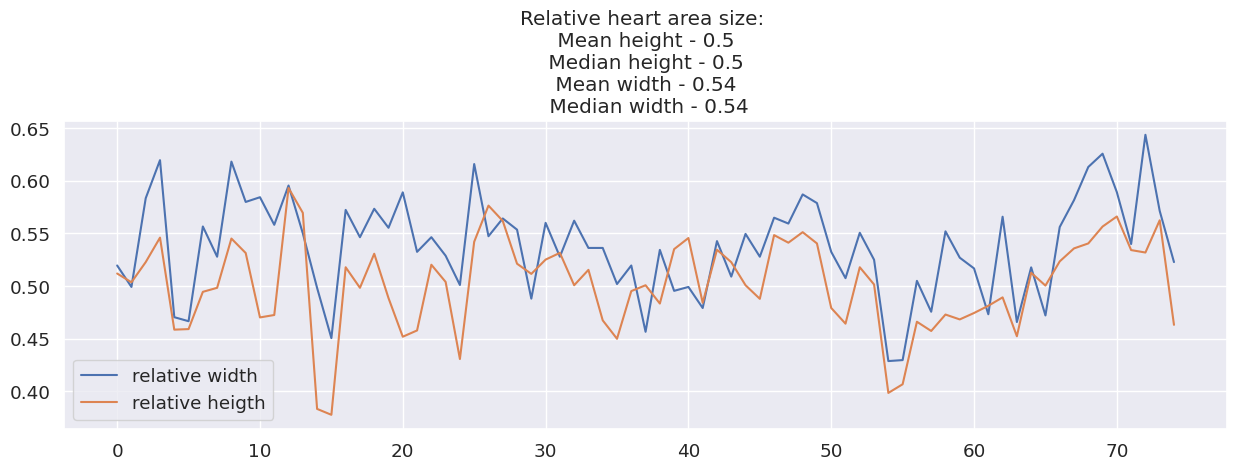

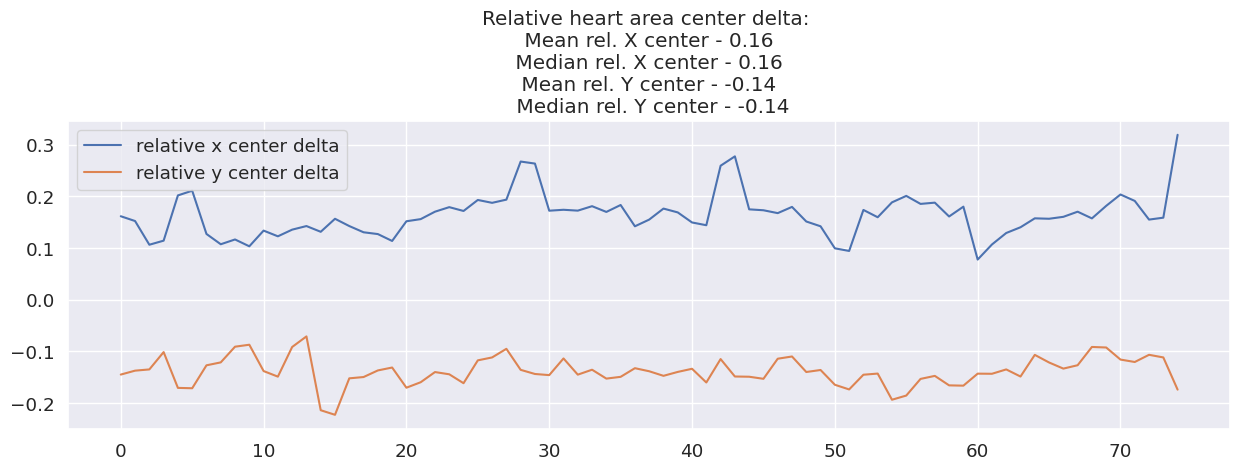

In [20]:
plt.plot(rel_w)
plt.plot(rel_h)
plt.title(f'Relative heart area size: \n Mean height - {st.mean(rel_h):.2} \n Median height - {st.median(rel_h):.2} \n Mean width - {st.mean(rel_w):.2} \n Median width - {st.median(rel_w):.2}')
labels = ['relative width', 'relative heigth']
plt.legend(labels)
plt.show()
plt.plot(rel_dxc)
plt.plot(rel_dyc)
plt.title(f'Relative heart area center delta: \n Mean rel. X center - {st.mean(rel_dxc):.2} \n Median rel. X center - {st.median(rel_dxc):.2} \n Mean rel. Y center - {st.mean(rel_dyc):.2} \n Median rel. Y center - {st.median(rel_dyc):.2}')
labels = ['relative x center delta', 'relative y center delta']
plt.legend(labels)
plt.show()

### DataLoaders

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [22]:
def draw_mask(data):
    im, tg = data
    for i in range(len(im)):
        image = im[i]
        masks = tg[i]['masks'].bool()
        boxes = torch.tensor(tg[i]['boxes'])
        labels = tg[i]['parts']
        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]
        output_image = draw_bounding_boxes(image, (boxes).long(), labels, colors="red", font_size=2, width=3)
        output_image = draw_segmentation_masks(output_image, masks, alpha=0.5)
        plt.figure(figsize=(9, 9))
        plt.axis("off")
        plt.imshow(output_image.permute(1, 2, 0))
        plt.show()

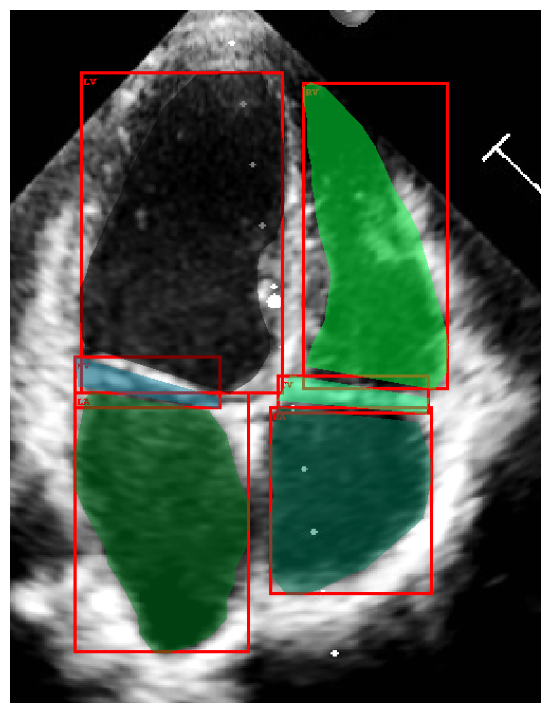

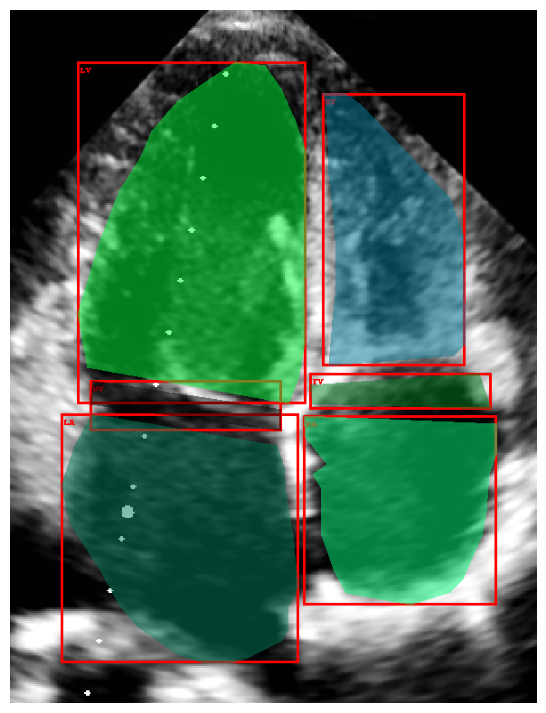

In [23]:
draw_mask(next(iter(train_dataloader)))

### Get Mask-RCNN Model and test run

In [24]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

In [25]:
num_classes = len(CLASSES_MASKS) + 1
seg_model = get_model_instance_segmentation(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 126MB/s]


In [26]:
# # For Training
# if device == 'cuda':
#     images, targets = next(iter(train_dataloader))
#     images = list(image.to(device) for image in images)
#     targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
#     output = seg_model(images, targets)  # Returns losses and detections
#     print(output)
#     # For inference
#     seg_model.eval()
#     predictions = seg_model(images)  # Returns predictions

### Training and evaluation functions

In [27]:
def metrics(predictions, true_values):
    iou = []
    map = []
    metric_1 = IntersectionOverUnion()
    metric_2 = MeanAveragePrecision(iou_type="segm")
    for p, t in zip(predictions, true_values):
        pboxes = ([{'boxes': p['boxes'], 'labels': p['labels']}])
        tboxes = ([{'boxes': t['boxes'], 'labels': t['labels']}])
        pmasks = ([{'masks': p['masks'].squeeze(1).bool(), 'scores': p['scores'], 'labels': p['labels']}])
        tmasks = ([{'masks': t['masks'].bool(), 'labels': t['labels']}])
        iou.append(metric_1(pboxes, tboxes)['iou'])
        metric_2.update(pmasks, tmasks)
        map.append(metric_2.compute()['map_50'])
    return sum(map), sum(iou)

In [28]:
def fit_epoch(model, train_loader, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for inputs, targets in train_loader:
        inputs = list(image.to(device) for image in inputs)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        if not math.isfinite(losses):
            print(f"Loss is {losses}, stopping training")
            sys.exit(1)
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
        processed_data += len(inputs)

    if scheduler is not None:
        scheduler.step()
    train_loss = running_loss / processed_data
    return train_loss

In [29]:
def eval_epoch(model, val_loader):
    model.eval()
    running_map = 0.0
    running_iou = 0.0
    processed_size = 0

    for inputs, targets in val_loader:
        inputs = list(image.to(device) for image in inputs)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(inputs)
        map, iou = metrics(outputs, targets)
        running_map += map
        running_iou += iou
        processed_size += len(inputs)
    val_iou = running_iou.cpu().numpy() / processed_size
    val_map = running_map.cpu().numpy() / processed_size
    return val_iou, val_map

In [30]:
def trainer(train, val, model, epochs, rate):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.3f} \
    val_iou {v_iou:0.3f} val_map50 {v_map:0.3f}\n"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        params = [p for p in model.parameters() if p.requires_grad]
        # opt = torch.optim.SGD(params, lr=rate, momentum=0.9, weight_decay=0.0005)
        opt = torch.optim.Adam(params, lr=rate)
        sch = None # lr_scheduler.StepLR(opt, step_size=10, gamma=0.2)
        final_metric = 0
        for epoch in range(epochs):
            if epoch == 0:
               warmup_factor = 1.0 / 1000
               warmup_iters = min(1000, len(train) - 1)

               sch = torch.optim.lr_scheduler.LinearLR(opt, start_factor=warmup_factor,
                                                                total_iters=warmup_iters)
            # else:
                # sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
            train_loss = fit_epoch(model, train, opt, sch)
            val_iou, val_map = eval_epoch(model, val)
            if val_iou > final_metric:
                torch.save(model.state_dict(), os.path.join(modelDir, 'mask_heart.pth'))
                print(f'save best model for {epoch} epoch')
                final_metric = val_iou
            history.append((train_loss, val_iou, val_map))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_iou=val_iou, v_map=val_map))

    loss, iou, map = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(iou, label="IoU Metric")
    plt.plot(map, label="MaP50 Metric")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("metrics")
    plt.show()

### Alternative way with ready training scripts from torchvision repo

In [31]:
# @title
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [32]:
# @title

# from engine import train_one_epoch, evaluate
# params = [p for p in seg_model.parameters() if p.requires_grad]
# # optimizer = torch.optim.SGD(
# #     params,
# #     lr=0.0005,
# #     momentum=0.9,
# #     weight_decay=0.0005
# # )

# optimizer = torch.optim.Adam(params, lr=5e-4)

# # and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=3,
#     gamma=0.1
# )

# num_epochs = 10

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(seg_model, optimizer, train_dataloader, device, epoch, print_freq=5)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(seg_model, valid_dataloader, device=device)

### Training MASK-RCNN (unseccessful)

In [33]:
# trainer(train_dataloader, valid_dataloader, model=seg_model, epochs=10, rate=3e-4)

In [34]:
# seg_model.load_state_dict(torch.load(os.path.join(modelDir, 'mask_heart.pth'), map_location=torch.device(device)))

### Evaluate on test data

In [35]:
def draw_eval_mask(data, model, threshold):
    model.eval()
    im, tg = data
    for i in range(len(im)):
        image = im[i].to(device)
        with torch.no_grad():
            output = seg_model([image, ])[0]
        tmasks = tg[i]['masks'].bool()
        tboxes = torch.tensor(tg[i]['boxes'])
        scores = list(output['scores'])
        imp = 0
        for sc in scores:
            if sc >= threshold:
                imp += 1
        pboxes = output['boxes'][:imp]
        pmasks = output['masks'].squeeze(1).bool()[:imp]
        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]
        output_image = draw_bounding_boxes(image, (tboxes).long(), colors="red", font_size=2, width=3)
        output_image = draw_segmentation_masks(output_image, tmasks, alpha=0.3, colors=["red"]*len(tmasks))
        output_image = draw_bounding_boxes(output_image, (pboxes).long(), colors="blue", font_size=2, width=3)
        output_image = draw_segmentation_masks(output_image, pmasks, alpha=0.5)
        plt.figure(figsize=(9, 9))
        plt.axis("off")
        plt.imshow(output_image.permute(1, 2, 0))
        plt.show()

|Description|Epochs|IoU, %|MaP50, %|
|--|--|--|--|
|Baseline|10|7|0,2|
|Baseline + step scheduler|30|3|0|
|Baseline + contrast|10|9|0|
|Baseline + contrast + augmentation|10|1|0|
|Baseline only heart&valves|10|15|7|
|Baseline only heart&valves + crop|10|2|20|

## Part II YOLO

In [38]:
ultralytics.checks()
y_model = YOLO('yolov8m-seg.pt')

Ultralytics YOLOv8.2.3 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/107.7 GB disk)


100%|██████████| 52.4M/52.4M [00:00<00:00, 313MB/s]


### Transform dataset to YOLO format

In [39]:
def save_yolo(data: torch.utils.data.dataset.Dataset, pth: str, mode: str):
    '''save tensors from torch dataset to disk,
    transforms masks to contours (relative coordinates)'''
    for i in tqdm(range(len(data)), desc=f'preparing YOLO {mode} folder'):
        im_pth = os.path.join(pth, 'datasets', mode, 'images', f"img_{i}.png")
        torchvision.utils.save_image(data[i][0], im_pth)
        ann_pth = os.path.join(pth, 'datasets', mode, 'labels', f"img_{i}.txt")
        with open(ann_pth, 'w') as fid:
            for j in range(len(data[i][1]['labels'])):
                mask = data[i][1]["masks"][j].numpy()
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                cnt = max(contours, key = cv2.contourArea)
                # bcg = np.ones((mask.shape[0], mask.shape[1]), dtype=np.int8)
                # p = cv2.drawContours(bcg, cnt, -1, (0,255,0), 3)
                # plt.imshow(p)
                # plt.show()
                xy = np.transpose(cnt.squeeze())
                x_yl = list(xy[0] / mask.shape[1])
                y_yl = list(xy[1] / mask.shape[0])
                if max(x_yl) > 1 or max(y_yl) > 1:
                    raise Exception('incorrect coordinates')
                y_m = []
                for xx, yy in zip(x_yl, y_yl):
                    y_m.append(xx)
                    y_m.append(yy)
                coords = list(map(lambda x: str(round(x, 3)), y_m))
                fid.write(f'{data[i][1]["labels"][j] - 1} {" ".join(coords).replace(",", "")}\n')

In [40]:
def prepare_yolo(data: torch.utils.data.dataset.Dataset, pth: str):
    '''prepare YOLO dataset, yaml file and folders'''
    shutil.rmtree(os.path.join(pth, 'datasets'), ignore_errors=True)
    os.mkdir(os.path.join(pth, 'datasets'))
    os.mkdir(os.path.join(pth, 'datasets', 'train'))
    os.mkdir(os.path.join(pth, 'datasets', 'val'))
    os.mkdir(os.path.join(pth, 'datasets', 'test'))
    os.mkdir(os.path.join(pth, 'datasets', 'train', 'images'))
    os.mkdir(os.path.join(pth, 'datasets', 'train', 'labels'))
    os.mkdir(os.path.join(pth, 'datasets', 'val', 'images'))
    os.mkdir(os.path.join(pth, 'datasets', 'val', 'labels'))
    os.mkdir(os.path.join(pth, 'datasets', 'test', 'images'))
    os.mkdir(os.path.join(pth, 'datasets', 'test', 'labels'))
    yaml_content = f'''
    train: train/images
    val: val/images
    test: test/images

    names: {list(CLASSES_MASKS.keys())}
    '''

    with open(os.path.join(pth, 'data.yaml'), 'w+') as fid:
        fid.write(yaml_content)
    train, valid, test = torch.utils.data.random_split(data, [.7, .2, .1], generator=SEED)
    save_yolo(train, pth, 'train')
    save_yolo(valid, pth, 'val')
    save_yolo(test, pth, 'test')

In [41]:
prepare_yolo(data, '/content')

preparing YOLO test folder: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


In [42]:
def test_yolo(pth: str, idx: int):
    '''test contiurs with relative coordinates'''
    path = os.path.join(pth, f'datasets/train/images/img_{idx}.png')
    l_path = os.path.join(pth, f'datasets/train/labels/img_{idx}.txt')
    image = Image.open(path).convert('L')
    image = tv_tensors.Image(image).permute(1, 2, 0).numpy()
    with open(l_path, 'r') as fid:
        content = fid.readlines()
    contours = []
    for c in content:
        clist = c.split(' ')
        label = int(clist[0])
        xy = list(map(float, clist[1:]))
        xx = []
        yy = []
        for j in range(0, len(xy), 2):
            xx.append(int(xy[j] * image.shape[1]))
            yy.append(int(xy[j + 1] * image.shape[0]))
        coord = torch.cat((torch.tensor(xx).unsqueeze(1), torch.tensor(yy).unsqueeze(1)), dim=1).unsqueeze(0).numpy()
        contours.append(coord)
    cv2.drawContours(image, contours, -1, (255,0,0), 3)
    plt.imshow(image)
    plt.axis("off")

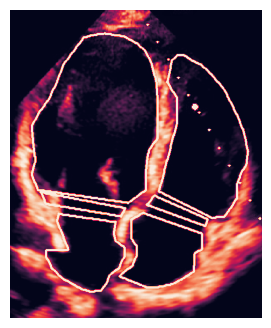

In [43]:
test_id = np.random.randint(len(os.listdir('/content/datasets/train/images')))
test_yolo('/content', test_id)

### Training loop

In [44]:
# shutil.rmtree('/content/runs/segment', ignore_errors=True)
train_status = False
if train_status:
    results = y_model.train(batch=8, device=device, data="data.yaml", epochs=60, imgsz=640)
    show_image(filename="/content/runs/segment/train/results.png", width=1000)

In [45]:
test_data = list(map(lambda x: os.path.join('/content/datasets/test/images', x), os.listdir('/content/datasets/test/images')))

In [46]:
best_model = YOLO('/content/drive/MyDrive/Colab Notebooks/template/models/best.pt')
results = best_model(test_data, conf=.25, iou=.5, save=True)


0: 640x640 1 LA, 2 LVs, 1 RA, 1 RV, 1 MV, 1 TV, 3988.4ms
1: 640x640 1 LV, 2 RAs, 1 RV, 1 MV, 1 TV, 3988.4ms
2: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 3988.4ms
3: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 3988.4ms
4: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 3988.4ms
5: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 3988.4ms
6: 640x640 1 LA, 1 LV, 1 RA, 1 RV, 1 MV, 1 TV, 3988.4ms
Speed: 12.1ms preprocess, 3988.4ms inference, 40.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


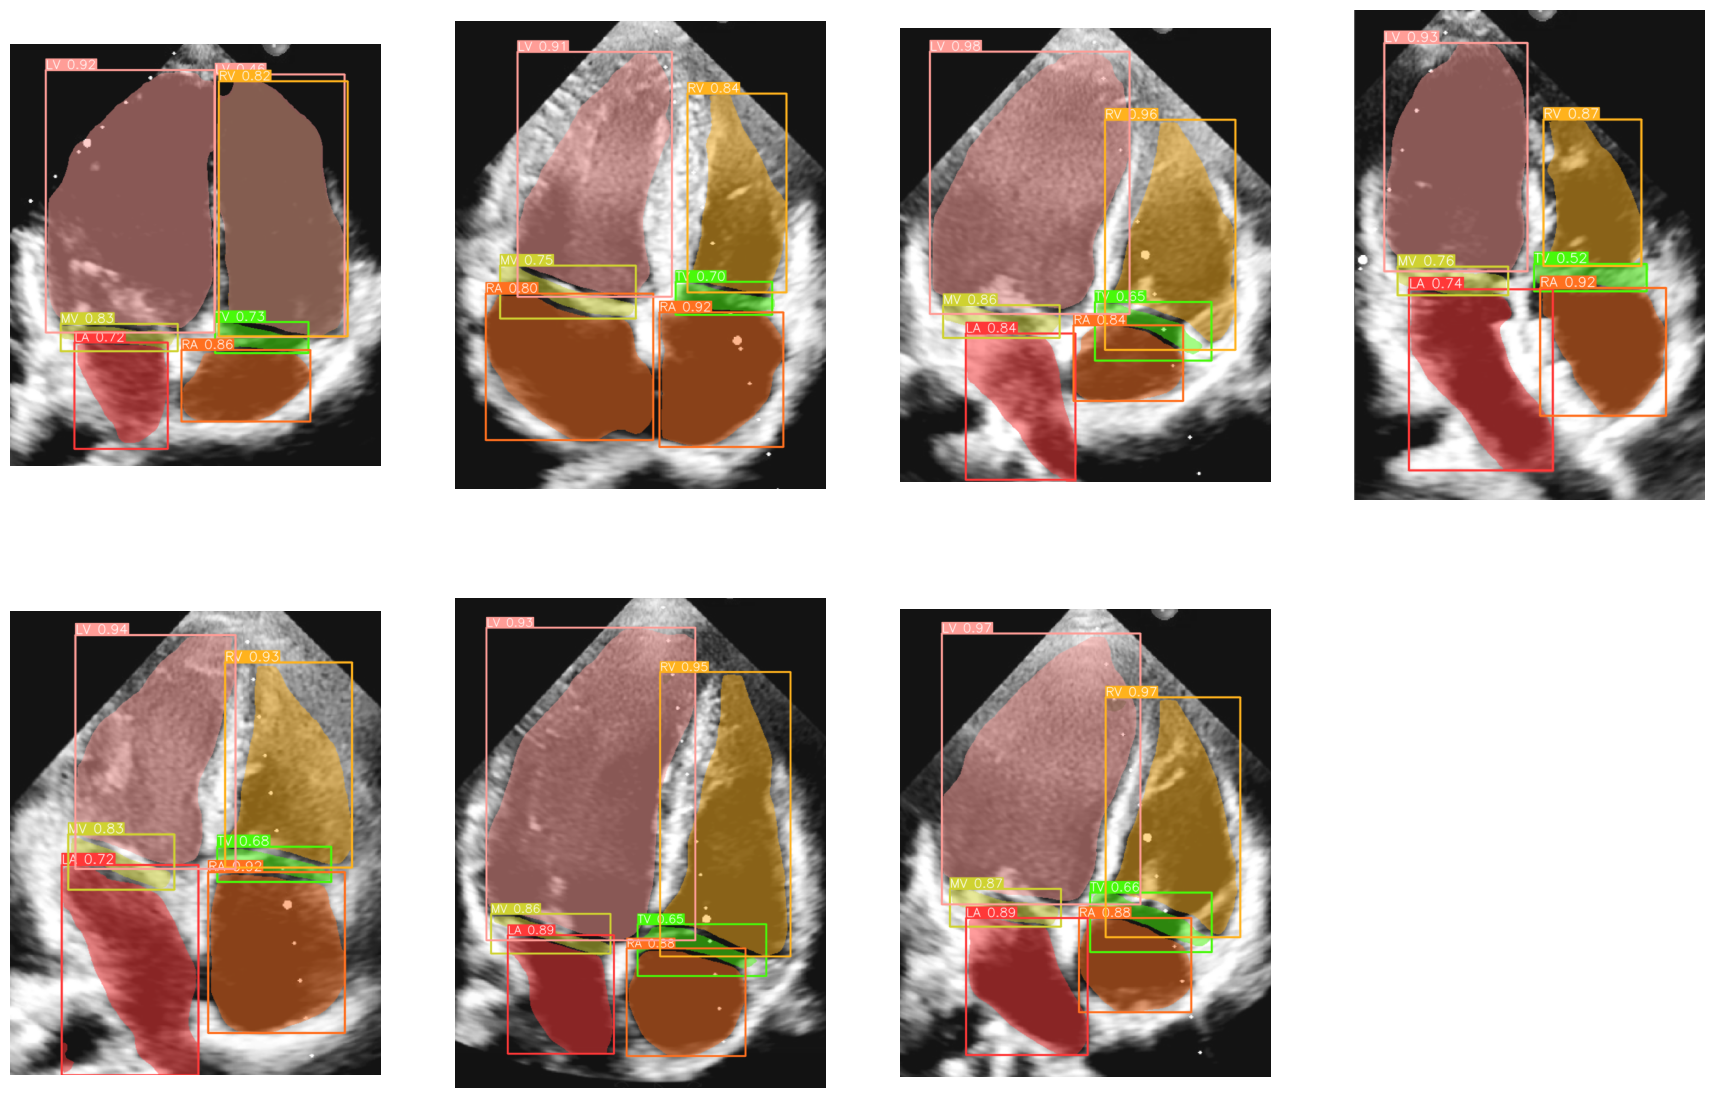

In [47]:
res_dir = "/content/runs/segment/predict/"
files = os.listdir(res_dir)
fig = plt.figure(figsize=(22,14))
for i in range(len(files)):
    fig.add_subplot(2, math.ceil(len(files) / 2), i+1)
    look = Image.open(os.path.join(res_dir, files[i]))
    plt.axis("off")
    plt.imshow(look)
plt.show()

### Inference for Video

In [50]:
def segment(video_path: str, model_path: str, start: int, fstep: int, crop: list) -> dict:
    model = YOLO(model_path)
    cap = cv2.VideoCapture(video_path)
    stop = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    lv_area = []
    frames = []
    for fr in tqdm(range(start, stop, fstep), desc=f'processing ECHO'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, fr)
        _, frame = cap.read()
        new_w = int(frame.shape[1] * crop[1])
        new_h = int(frame.shape[0] * crop[0])
        new_left = int(frame.shape[1] / 2 + crop[3] * new_w - new_w / 2)
        new_top = int(frame.shape[0] / 2 + crop[2] * new_h - new_h / 2)
        frame = frame[new_top:new_top + new_h, new_left:new_left + new_w]
        frame_m = frame
        result = model(frame, verbose=False)
        classes = result[0].names
        if len(classes) == 0:
            pass
        overlay = frame.copy()
        color_list = [(255, 0, 0),
                      (255, 255, 0),
                      (255, 0, 255),
                      (0, 255, 0),
                      (0, 0, 255),
                      (128, 128, 128)]
        for i, res in enumerate(result[0]):
            bx = res.boxes
            m = res.masks.xy
            label = int(bx.cls.squeeze().cpu())
            if label == 1:
                lv_area.append(cv2.contourArea(m[0]))
            box = list(map(int, bx.xyxy.squeeze().cpu().tolist()))
            cv2.rectangle(overlay, (box[0], box[1]), (box[2], box[3]), (36,255,12), 2)
            cv2.putText(overlay, classes[label], (box[0], box[1] - 5), cv2.FONT_HERSHEY_TRIPLEX, 1, (0,0,255), 2)
            cv2.fillPoly(overlay, pts=np.int32([m]), color=color_list[i%6])
            alpha = 0.4
            frame_m = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
        frames.append(frame_m)
        message = 'Video processing succeeded'
        if len(lv_area) == 0:
            message = 'Video processing failed'
    return lv_area, frames, message


In [54]:
heart_area = [.54, .5, -.14, .16]
vp = '/content/drive/MyDrive/Colab Notebooks/template/video/4к1.avi'
mp = '/content/drive/MyDrive/Colab Notebooks/template/models/best.pt'
lva, frames, msg = segment(vp, mp, 0, 1, heart_area)

processing ECHO: 100%|██████████| 118/118 [04:23<00:00,  2.24s/it]


In [58]:
def plotter(lv_data: list, window: int) -> dict:
    """
    plots the rolling mean graph for LV area.
    calculates the ejection fracture (average or maximum - I havent decided yet)
    """
    lv_rolling = pd.Series(lv_data).rolling(window=window).mean().dropna()
    # lv_norm = list(lv_rolling - lv_rolling.mean())
    # pos2neg = []
    # for i in range(len(lv_norm) - 1):
        # if lv_norm[i + 1] < 0 and lv_norm[i] > 0:
            # pos2neg.append(i)
        # i += 1

    # extrs = []
    # for i in range(len(pos2neg) - 1):
      #  part = lv_rolling[pos2neg[i]: pos2neg[i+1]]
      #  extrs.append((max(part) - min(part)) / max(part))
    ef = (max(lv_rolling) - min(lv_rolling)) / max(lv_rolling)
    plt.plot(lv_rolling)
    plt.grid(True)
    # plt.title(f'Average ejection fraction - {sum(extrs) / len(extrs):.1%}')
    plt.title(f'Ejection fraction - {ef:.1%}')
    plt.xlabel('Frames')
    plt.ylabel('left ventricle visible area, px*px')
    # return {'number_of_periods': len(extrs)}

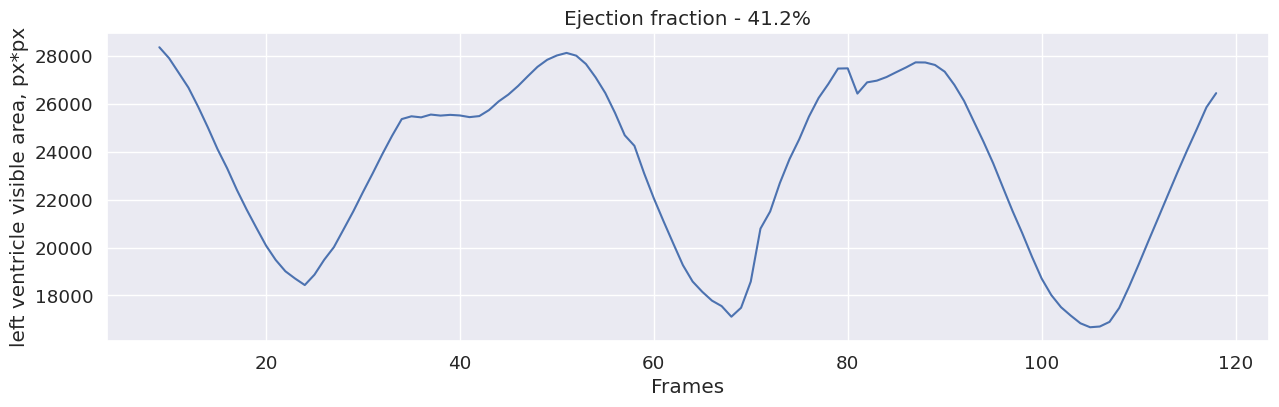

In [59]:
plotter(lva, 10)

### Write the result

In [60]:
def vidwrite(fn, images, framerate=25, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width,channels = images.shape
    process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in images:
        process.stdin.write(
            frame
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [61]:
res_path = '/content/drive/MyDrive/Colab Notebooks/template/video/result.mp4'

In [62]:
vidwrite(res_path, frames)

In [63]:
video = media.read_video(res_path)
media.show_video(video, fps=25)

## Part III Pretrained U-Net (Very Bad Idea:))

In [ ]:
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


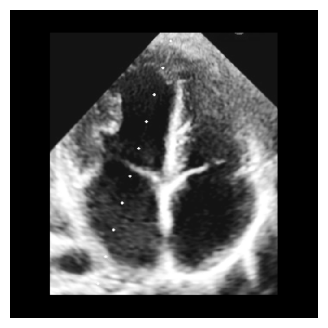

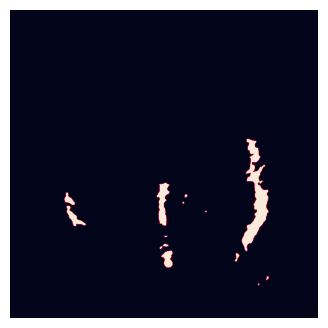

In [ ]:
test_id = np.random.randint(len(os.listdir('/content/datasets/train/images')))
filename = os.path.join('/content', f'datasets/train/images/img_{test_id}.png')
input_image = Image.open(filename).convert('RGB')
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=m, std=s),
    T.CenterCrop((640, 640))
])
input_tensor = preprocess(input_image)
# input_tensor.shape
input_batch = input_tensor.unsqueeze(0)


input_batch = input_batch.to(device)
unet = unet.to(device)

with torch.no_grad():
    output = unet(input_batch).squeeze(0)

# image = (255.0 * (input_tensor - input_tensor.min()) / (input_tensor.max() - input_tensor.min())).to(torch.uint8)
# image = image[:3, ...]
# output_image = draw_segmentation_masks(image, output.bool(), alpha=0.3, colors=["red"]*len(output))
plt.imshow(input_tensor.permute(1, 2, 0))
plt.axis("off")
plt.show()
plt.imshow(output.cpu().permute(1, 2, 0))
plt.axis("off")
plt.show()

## Uselul links

https://humanheart-project.creatis.insa-lyon.fr/database/#collection/6373703d73e9f0047faa1bc8

https://towardsdatascience.com/trian-yolov8-instance-segmentation-on-your-data-6ffa04b2debd


https://docs.ultralytics.com/modes/train/#train-settings

https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation